# How to find and group outliers in a logstream, based on behaviour

## Context

Your boss asked you to find suspect users among the few thousands of customers using your web site every day.

Where do you start?! Easy! AI, Tensorflow, machine learning, and other buzzwords like so will solve the issue! When all logs are categorized, it's quite easy right?! You know what is going on in your logs right?

... most probably not, especially if your site is generating few gigabytes of logs per day, there is just too much logs to know everything that is going one.

Before even starting to search for suspicious users, step 1 would be starting by identifying what it means to be suspicious.

    Suspicious normally means that it stands out from the normal.
    
Ok, step 2: what is normal?

    Normal behaviour consist of expected usage. Anything outside of this can be considered abnormal.

... We are not much more advanced because now we need to go over each action, and identify what is normal, and what is not, and assign a score to each.

The second issue with this is that normal behaviour will be definition be way more likely than the abnormal one, which will skew the results into making any machine learning model think that 99.9% of the usage is normal, which a margin of error of + or - 5%, flooding your analysis with noise.

The classical approach is to use a simple rule based system. By setting few triggers, we can find out account attackers. For small scale or simple systems, this will is likely to be enough, but not for large scale and complex systems.

One other hypothesis would be to use Hidden Markov Chains, but for HNN, we need to know what we are searching for.
Logs are also noisy: users will not simply go from A to B then C. they might crawl the whole site before reaching C, which complicates the creation of HMM.

Another hypothesis would be to filter out known noise, like when we want to do sentiment analysis, English stop words are just too common and does not tell us anything useful... but what if these stop words are useless in small quantities, but an indicator of an issue in large quantities? ... and how much is too much?


## Information Theory To The Rescue

Information Theory is normally used for signal analysis and compression. By using Surprisal Analysis and Kullback–Leibler divergence, we can group similar behaviour togethers.

* [Information Content](https://en.wikipedia.org/wiki/Information_content)
* [Surprisal Analysis](https://en.wikipedia.org/wiki/Surprisal_analysis)
* [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)
* [Example of Surprisal](http://www.umsl.edu/~fraundorfp/egsurpri.html)

Basically, Surprisal Analysis is a way to measure (in bits) how surprised we will be by looking at something. Surprisal are calculated using Log base 2, which makes it easy to calculate because log are additive when probabilities are multiplied.

For example:
* There is 1/6 chance to roll a 6 die, gives us 2.58 bits of information (-log2(1/6) ~= 2.4849 bits). If you are playing D&D, you will be happily surprised.
* Not rolling a 6 on a die represents 0.263 bits (-log2(5/6) ~= 0.263 bits). So rolling anything but a 6 in that same D&D game will most likely leave you dissapointed. 
* The chance of rolling 10 x 6 in a row on a die is 1/60466176 (10 * -log2(1/6) ~= 25.85 bits). This is highly unlikely.

By assigning a surprisal value to each action taken over all actions taken by all users gives us an idea how much surprisal by seeing any of them happening, and by adding the score of all actions of a user, we can get an idea how "normal" was all his/her actions.

This is what this notebook intend to demonstrate: Using Surprisal analysis, we will assign a score to actions, and by adding up the score of each action, identify series of actions that are unlikely to occur.

# But first, we need some logs

What is explained in this notebook can be applied to real logs, but for the experimentation, I added a "blackbox" library that will help to generate our users and the logs of these users based on a determined probability distribution.

## Caviat: I had to cheat to achieve the desired results

Because I am generating the logs through a known distribution, I am also able to know the type of user of each user, which makes it easy later on to debug and know how wrong I am.

This cheat was also necessary to get a probability distribution of the classification function of this notebook. This probability distribution is likely to be different for live environment, and should be tweeked.

| | Positive | Negative |
| -- | -- | -- |
| True | 0.875 | 0.102 |
| False | 0.125 | 0.898 |

I am using this probability distribution, along with the Bayes Theorem to update my belief that each tested candidates truely belong in the tested behaviour classification.

## Different User Profiles Generated By The Library

The following profiles are generated by the library.

Normal users
* Buyer
* Merchants

Abnormal users:
* Scraper bots
* Spammers
* fraudster
* Account Attackers

Buyers and merchants represent 98% of our logs. Leaving 2% to the abnormal users. However, the actions taken by each users being on a probability distribution, it is possible to see an "attakcer" user being classified as a user, because that attacked might have had a change of heart and didn't attack after all.

In [1]:
## This cell initialize the libraries needed for this notebook, 
## along with the blackbox functions used to generate the users and logs

import random
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta
from math import log, pow

%load_ext autoreload
%autoreload 2

from blackbox import distribution
from blackbox import generate_userlist, generate_logs, cheat_calculate_hit_rate, cheat_lookup_all_users

magic = distribution()

# Generating The User Database

The following cell generates our user database.

You will notice in this notebook that we are reinitializing the random seed quite often, just to keep consistence during the testing. Set the *random_seed* to False to randomize everything.

In [2]:
random_seed = 42

if random_seed:
    random.seed(random_seed)

number_of_daily_users = 2000 # this code breaks over 4000 users... I need to find why
all_user_lists = [] # Later on, we can add users to our list by supplying it to the generate_userlist function

## We define how many new users to add
number_of_new_users = number_of_daily_users - len(all_user_lists)

all_user_lists = generate_userlist(all_user_lists, number_of_new_users)
todays_user_lists = random.sample(all_user_lists, number_of_daily_users)

print(len(todays_user_lists), todays_user_lists[:15])

2000 ['buyer', 'merchant', 'merchant', 'buyer', 'buyer', 'buyer', 'buyer', 'buyer', 'merchant', 'merchant', 'merchant', 'merchant', 'buyer', 'buyer', 'buyer']


# Generating Logs For Day 1

Note: The more users we have, the more log events will be generated. The probability distribution of each user ensures that they will start with a defined action, crawl the site following a defined pattern, and logout eventually, until the end of the day.

In [3]:
%%time
if random_seed:
    random.seed(random_seed)

start_time = datetime(2019,1,1,0,0)
day1_logs = generate_logs(todays_user_lists, start_time)

print(len(day1_logs), 'log events generated for', len(todays_user_lists), 'users')

40170 log events generated for 2000 users
CPU times: user 7.97 s, sys: 94.6 ms, total: 8.06 s
Wall time: 8.21 s


## Transforming the logs in a pandas dataframe

The transition surprisal lookup table used in this notebook calculates scores based on the movements of the users between each actions. For example:

* login (success) -> view_items (success) will result in a low surpisal value
* login (fail) -> buy_item (success) never happened. If this sequence happen, this should be a huge red flag.

In [4]:
def transform_logs_to_pandas(logs):
    data = pd.DataFrame(np.array(logs), columns=['time', 'user', 'path', 'status', 'uidx', 'realtype'])
    
    data['prev_path'] = data.groupby(['user'])['path'].shift(1)
    data['prev_path'] = data['prev_path'].fillna("")

    data['prev_status'] = data.groupby(['user'])['status'].shift(1)
    data['prev_status'] = data['prev_status'].fillna("")
    return data
    
day1_data = transform_logs_to_pandas(day1_logs)

print(day1_data.loc[(day1_data['path'] == 'login') & (day1_data['status'] == 'fail')].head())

                    time          user   path status  uidx  realtype  \
558  2019-01-01 00:46:39  merchant1316  login   fail  1316  merchant   
777  2019-01-01 00:59:12   attacker652  login   fail   652  attacker   
778  2019-01-01 00:59:15   attacker652  login   fail   652  attacker   
779  2019-01-01 00:59:19   attacker652  login   fail   652  attacker   
834  2019-01-01 01:03:14     buyer1472  login   fail  1472     buyer   

    prev_path prev_status  
558                        
777                        
778     login        fail  
779     login        fail  
834                        


The following cell generates the transition surprisal lookup table used to score each actions taken by the users.

The format is as follow:

```
['current path'],['previous path']: {
    'fail': 0, # How many time this action transition failed. (ex. View Items: Success, from: Login: Success)
    'success': 13, # How many time this action transition succeded (ex. View Items: Fail, from: Login: Success)
    'fsurprisal': 11.266786540694902, # Surprisal value if there is a failure happens
    'ssurprisal': 7.56634682255381 # Surprisal value if that action is successful.
    }
```

The surprisal value is directly related to the likelihood of an actions happening. If an actions is observed successfully few million times, then the successful surprisal value will be really low. However, the failure surprisal will be much higher if it never happens.

In [5]:
def init_transition_surprisal_lookup(data, key, prev_key, feature, success):
    surprisal = {}

    for pkey in data[key].unique():
        data_for_pkey = data.loc[(data[key] == pkey)]
        denum = len(data.loc[(data[key] == pkey)])

        for ppkey in data_for_pkey[prev_key].unique():
            ds = data_for_pkey.loc[(data_for_pkey[prev_key] == ppkey) & (data_for_pkey[feature] == success)]
            df = data_for_pkey.loc[(data_for_pkey[prev_key] == ppkey) & (data_for_pkey[feature] != success)]

            dsuccess = len(ds) * 1.0
            dfail = len(df) * 1.0

            if dsuccess == 0:
                dsuccess = 1.0 

            if dfail == 0:
                dfail = 1.0

            if (pkey not in surprisal.keys()):
                surprisal[pkey] = {}

            surprisal[pkey][ppkey] = {
                'success': len(ds), 
                'fail': len(df), 
                'ssurprisal': log(1/(dsuccess / denum),2), 
                'fsurprisal': log(1/(dfail / denum),2),
            }
    return surprisal

transition_surprisal = init_transition_surprisal_lookup(day1_data, 'path', 'prev_path', 'status', 'success')

In [6]:
def get_transition_surprisal(path, prev_path, surprisal, data):
    if path not in list(surprisal.keys()):
        denum = len(data)
        return {
            'fail': 0,
            'success': 0,
            'ssurprisal': log(1/(1/denum),2),
            'fsurprisal': log(1/(1/denum),2),
        }
    else:
        if prev_path not in list(surprisal[path].keys()):
            denum = len(data.loc[(data['path'] == path)])
            return {
                'fail': 0,
                'success': 0,
                'ssurprisal': log(1/(1/denum),2),
                'fsurprisal': log(1/(1/denum),2),
            }
        else:
            return surprisal[path][prev_path]

get_transition_surprisal('buy_item', 'login', transition_surprisal, day1_data)

{'fail': 0,
 'fsurprisal': 11.213711798105674,
 'ssurprisal': 6.965784284662088,
 'success': 19}

In [7]:
def get_user_transition_score(data, surprisal, key, feature, success_val):
    accumulator = {}
    key_last_path = {}
    
    for index,row in data.iterrows():
        if row[key] not in key_last_path.keys():
            key_last_path[row[key]] = ""
            
        if row[key] not in accumulator.keys():
            accumulator[row[key]] = {k:0 for k in data[feature].unique()}
            
        if row[feature] is success_val:
            accumulator[row[key]][row[feature]] += get_transition_surprisal(row[feature],key_last_path[row[key]], surprisal, data)['ssurprisal']
        else:
            accumulator[row[key]][row[feature]] += get_transition_surprisal(row[feature],key_last_path[row[key]], surprisal, data)['fsurprisal']

        key_last_path[row[key]] = row[feature]
                                    
    return accumulator


user_transition_score = get_user_transition_score(day1_data, transition_surprisal, 'user', 'path', 'success')

In [8]:
cumulative_score = [[v,sum(user_transition_score[v].values())] for v in [k for k in list(user_transition_score.keys())]]

df_cumulative_score = pd.DataFrame(cumulative_score, columns=['user', 'surprisal'])

avg = df_cumulative_score['surprisal'].mean()
std = df_cumulative_score['surprisal'].std()
df_cumulative_score['z'] = (df_cumulative_score['surprisal'] - avg) / std


In [9]:
df_cumulative_score.loc[df_cumulative_score['z'] >= 2].sort_values(by=['surprisal'], ascending=False)

,user,surprisal,z
686,bot272,51550.564081,39.684129
623,bot1295,25659.755591,19.690524
189,bot1323,4788.884029,3.573455
832,bot1292,3741.640951,2.764745
1867,bot321,3121.263258,2.285672


In [10]:
df_cumulative_score.sort_values(by=['surprisal'], ascending=False).tail(10)

,user,surprisal,z
1996,buyer528,16.301175,-0.112066
532,fraudster152,16.046740,-0.112263
1623,fraudster1221,16.046740,-0.112263
1988,attacker1699,10.959278,-0.116191
458,merchant1421,10.959278,-0.116191
5,buyer282,10.959278,-0.116191
391,fraudster184,10.959278,-0.116191
1833,attacker1512,10.959278,-0.116191
249,buyer1712,10.959278,-0.116191
1997,buyer1367,5.087463,-0.120726


In [11]:
np.seterr(divide='ignore', invalid='ignore', over='ignore')

if random_seed:
    np.random.seed(random_seed)

maxlimit = 1
maxtp = 0
mintn = 1
best_flat_lookup = {}

for l in range(2, 10):
    flat_status, flat_lookup = cheat_calculate_hit_rate(day1_data, user_transition_score, l)
    if maxtp <= flat_lookup[True][True] and mintn >= flat_lookup[True][False]:
        maxtp = flat_lookup[True][True]
        mintn = flat_lookup[True][False]
        maxlimit = l
        print('best', l, flat_lookup, maxtp, mintn, (maxtp+mintn)/2,maxlimit)
    
# maxlimit = 7
flat_status, flat_lookup = cheat_calculate_hit_rate(day1_data, user_transition_score, maxlimit)

print('limit', maxlimit)
print('count', True, flat_status[True])
print('count', False, flat_status[False])

print('percent', True, flat_lookup[True])
print('percent', False, flat_lookup[False])


best 2 {True: {True: 0.937984496124031, False: 0.12451577199778639}, False: {True: 0.06201550387596899, False: 0.8754842280022136}} 0.937984496124031 0.12451577199778639 0.5312501340609087 2
best 4 {True: {True: 0.9398496240601504, False: 0.12257348863006101}, False: {True: 0.06015037593984962, False: 0.877426511369939}} 0.9398496240601504 0.12257348863006101 0.5312115563451056 4
limit 4
count True {True: 120, False: 8}
count False {True: 226, False: 1582}
percent True {True: 0.9375, False: 0.125}
percent False {True: 0.0625, False: 0.875}


Can we cluster users together?


We will use two lists: 
- unclassified_users, which is a copy of the original user_score list, but not classified yet
- behaviour_types: this is a list of hashes, the key being the user type (normally type + n), and the value of that hash is an array with all the profiles of the users classified under that type

With these 2 lists, here is the idea:
- From the unclassified_users list, we will pick one at random
- Then we will pick 100 users at random, and try to find 10 that matches the behaviour. It's ok if we don't find any
- I make the hypothesis that we have 10 kind of users, so my prior probability is 0.1
- Then we check in all the keys under behaviour_types and compare our found random candidates with max 10 random candidates from that behaviour type. For the experimental data, We know that the True Positive probability is 51.5%, and the True Negative rate is 11.2%. By doing enough tests, we should be able to update our belief that we are comparing matching or different profiles

In [12]:
def update_probability(prior_probability, distribution, test_result):
    
    # What is our success rate for this test_result?
    likelihood_of_being_right = distribution[test_result][True]
    likelihood_of_being_wrong = distribution[test_result][False]
          
    numerator = likelihood_of_being_right * prior_probability
    denominator = (likelihood_of_being_right * prior_probability) + (likelihood_of_being_wrong * (1 - prior_probability))
    
    posterior_probability = numerator / denominator
    
    return posterior_probability

In [13]:
np.seterr(divide='ignore', invalid='ignore', over='ignore') 

def align_profiles(profile1, profile2):
    if profile1.keys() != profile2.keys():
        for k in profile1.keys():
            if k not in profile2.keys():
                profile2[k] = profile1[k]
        for k in profile2.keys():
            if k not in profile1.keys():
                profile1[k] = profile2[k]
    p1 = [value for (key, value) in sorted(profile1.items())]
    p2 = [value for (key, value) in sorted(profile2.items())]
    allkeys = [key for (key, value) in sorted(profile2.items())]
    return p1, p2, allkeys

def compare_profiles(profile1, profile2, limit = 7):
    u1, u2, trash = align_profiles(profile1, profile2)
    
    # Ref: https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Definition
    px = [1/np.power(2,x) for x in np.array(u1)]    
    qx = [1/np.power(2,x) for x in np.array(u2)]
    
    p = np.array(qx)/np.array(px)
    q = np.array(px)/np.array(qx)
    dklp = (qx * np.log2(p)).sum()
    dklq = (px * np.log2(q)).sum()
    
    t = (dklp < limit and dklp >= -limit) and (dklq < limit and dklq >= -limit)
    
    return {'test': t, 'dklp': dklp, 'dklq': dklq}

test_users = random.sample(user_transition_score.keys(),2)
print(test_users[0], user_transition_score[test_users[0]])
print(test_users[1], user_transition_score[test_users[1]])
compare_profiles(user_transition_score[test_users[0]], user_transition_score[test_users[1]], maxlimit)

merchant857 {'login': 5.08746284125034, 'view_item': 14.71112919630353, 'comment': 0, 'buy_item': 0, 'logout': 0, 'end': 10.959277505720502, 'sell_item': 10.349281228817453, 'home': 0, 'bank_modify': 0, 'view_profile': 0, 'password_reset': 0, 'payment_modify': 0, 'update_address': 0, 'update_email': 0}
merchant946 {'login': 5.08746284125034, 'view_item': 129.07211050631952, 'comment': 0, 'buy_item': 0, 'logout': 0, 'end': 10.959277505720502, 'sell_item': 102.84895609839981, 'home': 0, 'bank_modify': 0, 'view_profile': 0, 'password_reset': 0, 'payment_modify': 0, 'update_address': 0, 'update_email': 0}


{'dklp': -1.0127900003221136e-29, 'dklq': 0.0751718455254234, 'test': True}

In [14]:
def compile_average_for_type(array):
    garbage = {}
    for i in range(len(array)):
        if len(garbage.keys()) == 0:
            garbage = array[i]
        else:
            g, a, allkeys = align_profiles(garbage, array[i])
            c = np.array(g) + np.array(a)
            for idx in range(len(allkeys)):
                garbage[allkeys[idx]] = c[idx] 
    for k in garbage.keys():
        garbage[k] = garbage[k] / len(array)
    return garbage

array = [{'a':1,'b':2,'c':3}, {'a':1,'b':2,'c':3}, {'a':1,'b':2,'c':3, 'd':4}, {'a':3,'b':1,'c':4}]
compile_average_for_type(array)

{'a': 1.5, 'b': 1.75, 'c': 3.25, 'd': 4.0}

In [15]:
def add_candidate_to_behaviour_type(candidate_name, matching_class, behaviour_type_table):  
    if matching_class not in behaviour_type_table.keys():
        behaviour_type_table[matching_class] = []

    if candidate_name not in behaviour_type_table[matching_class]:
        behaviour_type_table[matching_class].append(candidate_name)
        
    return candidate_name

In [16]:
def remove_from_classification(candidate_name, behaviour_type_table):
    cleaneds = []
    empties = []
    for be, be_list in behaviour_type_table.items():
        if candidate_name in behaviour_type_table[be]:
            behaviour_type_table[be].remove(candidate_name)
            cleaneds.append(be)
        if len(behaviour_type_table[be]) == 0:
            empties.append(be)
    for e in empties:
        del behaviour_type_table[e]
            
    return cleaneds       

def classify_candidates_average(candidate_name, behaviour_type_average, score, limit = 7):
    potential_matching_type = {}
    passing_score = 0.9
    sample_size = 10
    small_size_adjustment = 2
    
    for be, be_average in behaviour_type_average.items():
        post = 0.1 # this is the prior

        result = compare_profiles(score[candidate_name], be_average, limit)
        post = update_probability(post, flat_lookup, result['test'])
            
        if result['test'] == True:
            potential_matching_type[be] = post

    if len(potential_matching_type.keys()) == 0:
        new_class_name = max(0,len(list(behaviour_type_average.values())))
        return new_class_name
    else:
        return max(potential_matching_type, key=potential_matching_type.get)
    
def classify_users_in_list(unclassified_user_lists, behaviour_type_table, behaviour_average_table, score, limit = 7):
    # select one user
    candidate_name = random.choice(unclassified_user_lists)
    if candidate_name:
        # classify user
        cleanup = remove_from_classification(candidate_name, behaviour_type_table)
        
        matching_class = classify_candidates_average(candidate_name, behaviour_average_table, score, limit)

        # add the user to the proper type
        add_candidate_to_behaviour_type(candidate_name, matching_class, behaviour_type_table)
        if len(behaviour_type_table[matching_class]) % 4 == 0 or len(behaviour_type_table[matching_class]) == 1:
            scores_for_users = random.sample(
                [score[x] for x in behaviour_type_table[matching_class]], 
                min(len(behaviour_type_table[matching_class]),10)
            )
            behaviour_average_table[matching_class] = compile_average_for_type(scores_for_users)
        unclassified_user_lists.remove(candidate_name)

In [27]:
if random_seed:
    random.seed(random_seed)

behaviour_type_table = {}
behaviour_average_table = {}
print(len(list(user_transition_score.keys())))
unclassified_user_lists = random.sample(list(user_transition_score.keys()), min(len(todays_user_lists), len(list(user_transition_score.keys()))))

1999


In [28]:
%%time
# while there are unclassified users
while len(unclassified_user_lists):
    classify_users_in_list(unclassified_user_lists, behaviour_type_table, behaviour_average_table, user_transition_score, maxlimit)

for k in behaviour_type_table.keys():
        type_average = np.mean([sum(user_transition_score[x].values()) for x in behaviour_type_table[k]])
        print(k, type_average, len(behaviour_type_table[k]), cheat_lookup_all_users(behaviour_type_table[k]))

0 136.212746254 524 {'merchant': 524}
1 91.5604730387 511 {'buyer': 511}
2 122.99995684 476 {'merchant': 476}
3 152.237587314 163 {'buyer': 163}
4 142.974370362 56 {'buyer': 56}
5 83.1915471671 201 {'buyer': 201}
6 125.098793623 4 {'buyer': 4}
7 10.9592775057 6 {'buyer': 2, 'fraudster': 1, 'attacker': 2, 'merchant': 1}
8 350.829429519 4 {'merchant': 4}
9 94.2536470715 4 {'attacker': 4}
10 38.7692550214 7 {'buyer': 7}
11 3741.64095064 1 {'bot': 1}
12 158.391936923 2 {'merchant': 2}
13 51550.5640814 1 {'bot': 1}
14 25659.7555907 1 {'bot': 1}
15 17.9298542566 3 {'fraudster': 2, 'attacker': 1}
16 5.08746284125 1 {'buyer': 1}
17 181.943107272 1 {'buyer': 1}
18 183.165776658 1 {'merchant': 1}
19 31.5748267938 2 {'buyer': 2}
20 181.700719883 1 {'buyer': 1}
21 16.3011746394 1 {'buyer': 1}
22 167.587890011 3 {'buyer': 2, 'fraudster': 1}
23 168.427842172 1 {'buyer': 1}
24 347.236844028 2 {'buyer': 2}
25 136.175813628 4 {'spammer': 4}
26 168.933119571 1 {'spammer': 1}
27 206.475582662 1 {'merchan

In [33]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib

def graph_user_distribution_by_behaviour_id(type_table, average_table):  
    current_behaviour_state_table = {}
    for k in type_table.keys():
        type_average = np.mean([sum(user_transition_score[x].values()) for x in type_table[k]])
        current_behaviour_state_table[k] = {'type': k, 'score':type_average, 'nbmembers':len(type_table[k]), 'behaviour': average_table[k]}
    
    plt.figure(figsize=(20,5))

    index = np.array(list(current_behaviour_state_table.keys()))
    names = list(type_table.keys())
    v1 = [current_behaviour_state_table[x]['nbmembers'] for x in names]
    plt.figure(1, figsize=(9, 5))

    bar_width = 0.4
    spare_width = (1 - bar_width*2)/2
#     opacity = 0.4

    rects1 = plt.bar(index, v1, bar_width,
                    color='b',
                    label='Nb Members')

    # rects2 = ax.bar(index + bar_width, v2, bar_width,
    #                 alpha=opacity, color='r',
    #                 label='Surprisal')

    plt.xlabel('Behaviour Cluster ID')
    plt.ylabel('Number of Users')
    plt.title('Number of User Per Behaviour Cluster')
    plt.xticks(index)
    plt.grid()
    plt.legend()
    return plt


# plt.show()

In [29]:
if 1: #graph debugging... ignore
    current_behaviour_state_table = {}

    for k in behaviour_type_table.keys():
        type_average = np.mean([sum(user_transition_score[x].values()) for x in behaviour_type_table[k]])
        current_behaviour_state_table[k] = {'type': k, 'score':type_average, 'nbmembers':len(behaviour_type_table[k]), 'behaviour': behaviour_average_table[k]}

    surprisal_stats = np.array([
        [current_behaviour_state_table[y]['behaviour'][x]/sum(current_behaviour_state_table[y]['behaviour'].values()) for x in sorted(current_behaviour_state_table[1]['behaviour'].keys())]
        for y in list(current_behaviour_state_table.keys())# [key for (key, value) in sorted(current_behaviour_state_table.items())]
    ])

    keylists_columns = list(current_behaviour_state_table.keys())
    path_rows = sorted(current_behaviour_state_table[keylists_columns[0]]['behaviour'].keys())
    surprisal_values = list(current_behaviour_state_table[keylists_columns[0]]['behaviour'].values())
    # np.array(surprisal_values) * current_behaviour_state_table[keylists_columns[0]]['nbmembers']

    x = [[1,2,3,4],
        ['a','b','c','d'],
        [4,5,6,7]
        ]
    # print(np.array(surprisal_values))

    #     p2 = [value for (key, value) in sorted(profile2.items())]
    #     allkeys = [key for (key, value) in sorted(profile2.items())]

    # print(path_rows)
    print(surprisal_stats[0])
    # print(sorted(current_behaviour_state_table[1]['behaviour'].keys()))


[  0.00000000e+00   0.00000000e+00   0.00000000e+00   9.05822673e-02
   0.00000000e+00   4.25817280e-02   8.49357676e-02   3.02053349e-05
   0.00000000e+00   3.70591666e-01   0.00000000e+00   0.00000000e+00
   4.11278366e-01   0.00000000e+00]


In [30]:
def graph_surprisal_distribution_by_type(type_table, average_table):
    current_behaviour_state_table = {}
    for k in type_table.keys():
        type_average = np.mean([sum(user_transition_score[x].values()) for x in type_table[k]])
        current_behaviour_state_table[k] = {'type': k, 'score':type_average, 'nbmembers':len(type_table[k]), 'behaviour': average_table[k]}
    
    surprisal_stats = np.array([
        [current_behaviour_state_table[y]['behaviour'][x] for x in sorted(current_behaviour_state_table[1]['behaviour'].keys())]
#         [current_behaviour_state_table[y]['behaviour'][x]/sum(current_behaviour_state_table[y]['behaviour'].values()) for x in sorted(current_behaviour_state_table[1]['behaviour'].keys())]
        for y in list(current_behaviour_state_table.keys())
    ]).T
    
    keylists_columns = np.array(list(current_behaviour_state_table.keys()))
    path_rows = sorted(current_behaviour_state_table[keylists_columns[0]]['behaviour'].keys())

    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(30.0,7.5)

    # https://matplotlib.org/examples/color/colormaps_reference.html
    colors = plt.cm.Paired(np.linspace(0, 0.75, len(path_rows)))

    n_rows = len(surprisal_stats)

    index = np.arange(len(keylists_columns)) + 0.4
    bar_width = 0.4
    spare_width = (1 - bar_width*2)/2
    
    ax.set_xlim(-spare_width,len(index)-spare_width)
    ax.set_ylabel("Surprisal Distribution")
    xTickMarks = keylists_columns
    
    ax.set_xticks(index+bar_width)
    
    xtickNames = ax.set_xticklabels(xTickMarks)
    plt.setp(xtickNames, rotation=0, fontsize=40)
    ax.yaxis.grid()

    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(keylists_columns))

    # Plot bars and create text labels for the table
    cell_text = []
    for row in range(n_rows):
        plt.bar(index, np.minimum(surprisal_stats[row],500), bar_width, bottom=y_offset, color=colors[row])
        y_offset = y_offset + np.minimum(surprisal_stats[row],500)
        cell_text.append(['%.2f' % x for x in surprisal_stats[row]])

    # Add a table at the bottom of the axes
    the_table = plt.table(cellText=cell_text,
                          rowLabels=path_rows,
                          rowColours=colors,
                          colLabels=keylists_columns,
                          loc='bottom')

    the_table.scale(1,2.5)
    
    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)
    ax.xaxis.labelpad = 260
    ax.yaxis.labelpad = 20

    plt.xticks([])
    plt.title('Distribution Of Actions By Behaviour Type')


<module 'matplotlib.pyplot' from '/Users/simon/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

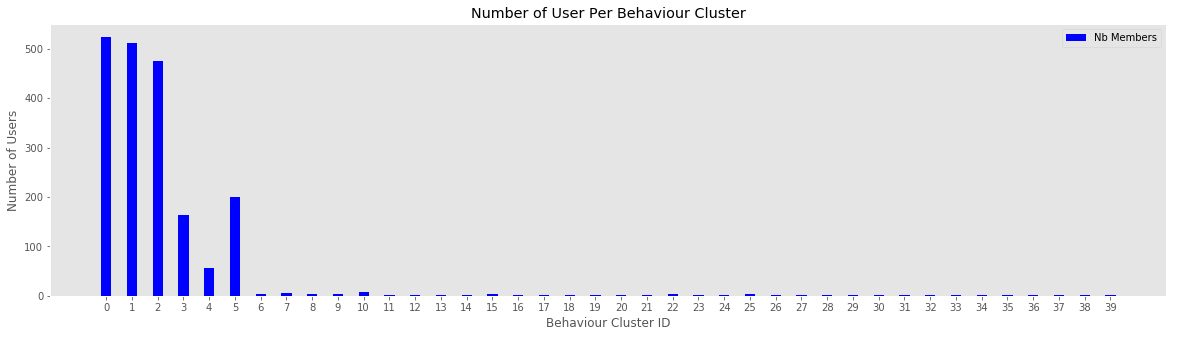

In [34]:
graph_user_distribution_by_behaviour_id(behaviour_type_table, behaviour_average_table)

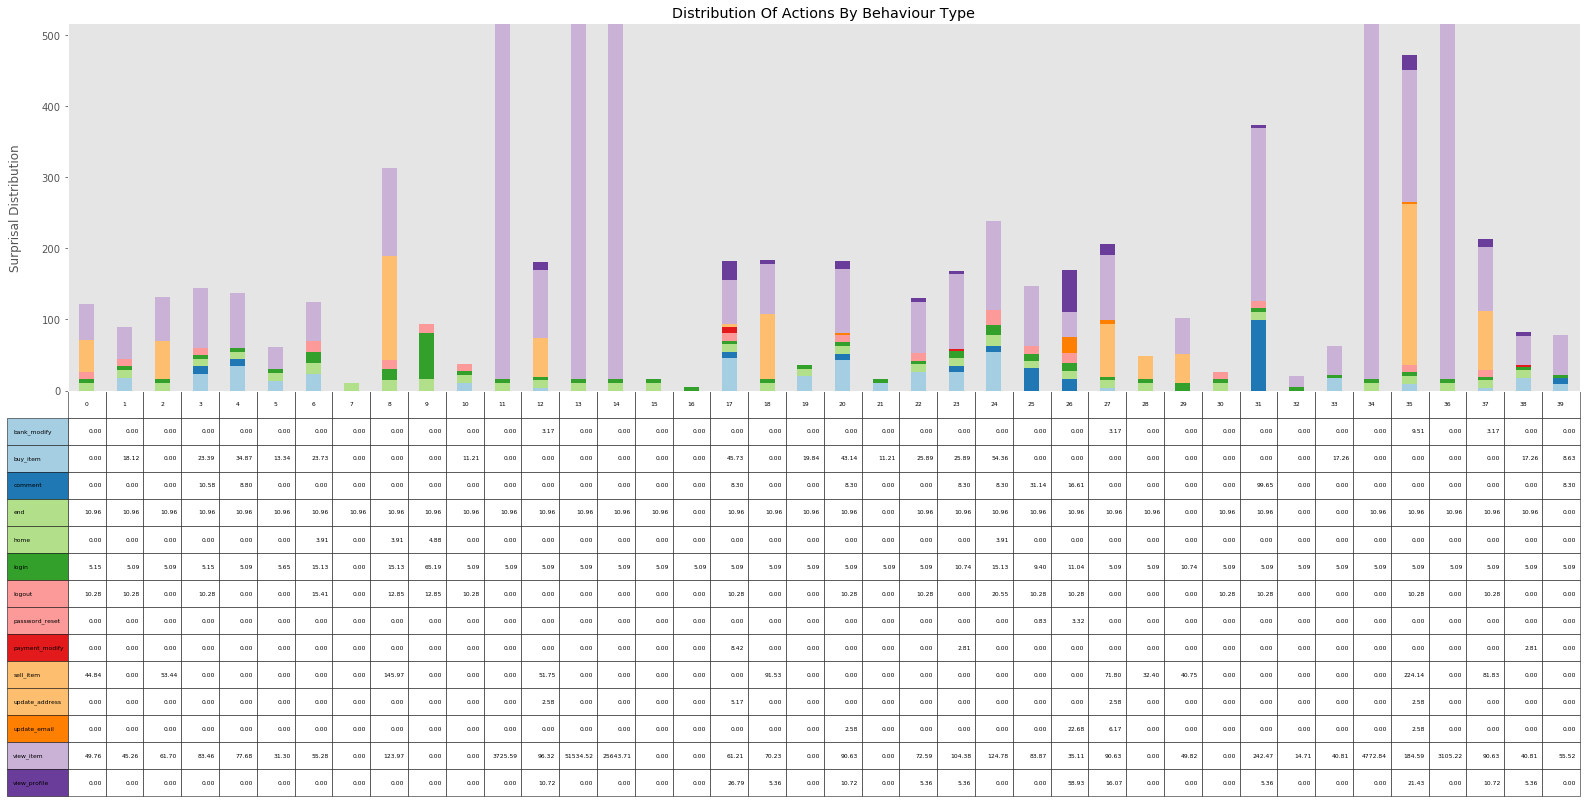

In [35]:
graph_surprisal_distribution_by_type(behaviour_type_table, behaviour_average_table)

In [64]:
df_investigate = day1_data.loc[day1_data['user'].isin(behaviour_type_table[35])]
df_investigate.groupby(['user', 'status', 'path']).size().unstack(fill_value=0)

path                  bank_modify  end  login  logout  sell_item  \
user         status                                                
merchant1249 fail               1    0      0       0          1   
             success            2    1      1       1         21   

path                  update_address  update_email  view_item  view_profile  
user         status                                                          
merchant1249 fail                  0             0          0             0  
             success               1             1         15             4

# Day 2, Let's see if we can find something

We are now Day 2. Surprisal values are based on a different day, but if the normal distribution is anything like Day 1, the surprisal value calculated should be still relevant.

Let's generate a new day of logs

In [ ]:
start_time = datetime(2019,1,2,0,0)

if random_seed:
    random.seed(random_seed + 1)

number_of_new_users = 200    
all_user_lists = generate_userlist(all_user_lists, number_of_new_users)

todays_user_lists = random.sample(all_user_lists, number_of_daily_users)
# maxlimit = max((len(todays_user_lists) * maxlimitrate), 1)

print(len(todays_user_lists), todays_user_lists[:5])

if random_seed:
    random.seed(random_seed + 1)
day2_logs = generate_logs(todays_user_lists, start_time)

print(len(day2_logs), 'logs events generated for', len(todays_user_lists), 'users')

day2_data = transform_logs_to_pandas(day2_logs)

In [ ]:
user_transition_score_day2 = get_user_transition_score(day2_data, transition_surprisal, 'user', 'path', 'success')

In [ ]:
def merge_user_transition_score(original, newtransitions):        
    for key in original.keys():
        if key not in newtransitions.keys():
            newtransitions[key] = original[key]

    return newtransitions

user_transition_score_merged = merge_user_transition_score(user_transition_score, user_transition_score_day2)
len(user_transition_score_merged)

In [ ]:
cumulative_score = [[v,sum(user_transition_score_merged[v].values())] for v in [k for k in list(user_transition_score_merged.keys())]]

df_cumulative_score = pd.DataFrame(cumulative_score, columns=['user', 'surprisal'])

avg = df_cumulative_score['surprisal'].mean()
std = df_cumulative_score['surprisal'].std()
df_cumulative_score['z'] = (df_cumulative_score['surprisal'] - avg) / std

df_cumulative_score.loc[df_cumulative_score['z'] >= 2].sort_values(by=['surprisal'], ascending=False)

In [ ]:
if random_seed:
    random.seed(random_seed)

unclassified_user_lists = random.sample(list(user_transition_score_merged.keys()), len(list(user_transition_score_merged.keys())))

In [ ]:
%%time
# while there are unclassified users
while len(unclassified_user_lists):
    classify_users_in_list(unclassified_user_lists, behaviour_type_table, user_transition_score_merged, maxlimit)

for k in behaviour_type_table.keys():
    type_average = np.mean([sum(user_transition_score_merged[x].values()) for x in behaviour_type_table[k]])
    print(k, type_average, len(behaviour_type_table[k]), cheat_lookup_all_users(behaviour_type_table[k]))

# Day 3: Automatically Classifying Users

At one point, we still need to classify behaviours. Using Naive Bayes over the actions, we can score each users to the likely category they belong too.

Could we have done that without looking for the outliers? Yes, but we still need to identify which users is normal and which one is likely not.

At first, we need to calculate the probability distribution of each actions for each categories.

In [ ]:
start_time = datetime(2019,1,3,0,0)

if random_seed:
    random.seed(random_seed + 1)

number_of_new_users = 200    
all_user_lists = generate_userlist(all_user_lists, number_of_new_users)

todays_user_lists = random.sample(all_user_lists, number_of_daily_users)

print(len(todays_user_lists), todays_user_lists[:5])

if random_seed:
    random.seed(random_seed + 1)
day3_logs = generate_logs(todays_user_lists, start_time)

print(len(day3_logs), 'logs events generated for', len(todays_user_lists), 'users')

day3_data = transform_logs_to_pandas(day3_logs)

In [ ]:
user_transition_score_day3 = get_user_transition_score(day3_data, transition_surprisal, 'user', 'path', 'success')
user_transition_score_merged = merge_user_transition_score(user_transition_score_merged, user_transition_score_day3)
len(user_transition_score_merged)

In [ ]:
if random_seed:
    random.seed(random_seed)

unclassified_user_lists = random.sample(list(user_transition_score_merged.keys()), len(list(user_transition_score_merged.keys())))

In [ ]:
%%time
# while there are unclassified users
while len(unclassified_user_lists):
    classify_users_in_list(unclassified_user_lists, behaviour_type_table, user_transition_score_merged, maxlimit)

for k in behaviour_type_table.keys():
    type_average = np.mean([sum(user_transition_score_merged[x].values()) for x in behaviour_type_table[k]])
    print(k, type_average, len(behaviour_type_table[k]), cheat_lookup_all_users(behaviour_type_table[k]))

# Day 4: Automatically Classifying Users

At one point, we still need to classify behaviours. Using Naive Bayes over the actions, we can score each users to the likely category they belong too.

Could we have done that without looking for the outliers? Yes, but we still need to identify which users is normal and which one is likely not.

At first, we need to calculate the probability distribution of each actions for each categories.

In [ ]:
start_time = datetime(2019,1,4,0,0)

if random_seed:
    random.seed(random_seed + 1)

number_of_new_users = 200    
all_user_lists = generate_userlist(all_user_lists, number_of_new_users)

todays_user_lists = random.sample(all_user_lists, number_of_daily_users)
maxlimit = max((len(todays_user_lists) * maxlimitrate), 1)

print(len(todays_user_lists), todays_user_lists[:5])

if random_seed:
    random.seed(random_seed + 1)
day4_logs = generate_logs(todays_user_lists, start_time)

print(len(day4_logs), 'logs events generated for', len(todays_user_lists), 'users')

day4_data = transform_logs_to_pandas(day4_logs)

In [ ]:
user_transition_score_day4 = get_user_transition_score(day4_data, transition_surprisal, 'user', 'path', 'success')
user_transition_score_merged = merge_user_transition_score(user_transition_score_merged, user_transition_score_day4)
len(user_transition_score_merged)

In [ ]:
if random_seed:
    random.seed(random_seed)

unclassified_user_lists = random.sample(list(user_transition_score_merged.keys()), len(list(user_transition_score_merged.keys())))

In [ ]:
%%time
# while there are unclassified users
while len(unclassified_user_lists):
    classify_users_in_list(unclassified_user_lists, behaviour_type_table, user_transition_score_merged, maxlimit)

for k in behaviour_type_table.keys():
    type_average = np.mean([sum(user_transition_score_merged[x].values()) for x in behaviour_type_table[k]])
    print(k, type_average, len(behaviour_type_table[k]), cheat_lookup_all_users(behaviour_type_table[k]))